In [1]:
import os

import torch
from hydra import compose, initialize
from torch.utils.data import DataLoader

from src.components.dvi.cmcd import CMCD
from src.utils.grid import (compute_bd, compute_jsd, compute_lmpl, create_grid,
                            eval_dist_on_grid, eval_hist_on_grid,
                            eval_kde_on_grid)
from src.utils.load import load_dvinp
from src.utils.visualize import (visualize_dvinp, visualize_dvinp_both,
                                 visualize_vals_on_grid_2d)

In [2]:
try:
    import torch_directml
    device = torch_directml.device() 
except ImportError:
    device = torch.device("cpu") 
print(device)

privateuseone:0


In [3]:
dir = "../models/test"  

In [4]:
with initialize(version_base=None, config_path=dir):
    cfg = compose(config_name="cfg")

    dvinp, trainer = load_dvinp(cfg, device)

    path = f"{dir}/dvinp.pth"

    if os.path.exists(path):
        state_dict = torch.load(path, map_location=torch.device("cpu"), weights_only=False)
        dvinp.load_state_dict(state_dict)
        print(f"loaded dvinp from {path}")

    # dvinp.cdvi = CMCD(
    #     device=device, 
    #     z_dim=cfg.common.z_dim,
    #     num_steps=cfg.dvi_process.num_steps,
    #     control=None,
    # )

Generating tasks: 100%|██████████| 4096/4096 [00:00<00:00, 269703.91it/s]
Dropped Escape call with ulEscapeCode : 0x03007703


loaded dvinp from ../models/test/dvinp.pth


/home/chickencurry/miniconda3/envs/directml/lib/python3.11/site-packages/torch/distributions/normal.py:71: UserWarning: The operator 'aten::normal.Tensor_Tensor' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /__w/1/s/pytorch-directml-plugin/torch_directml/csrc/dml/dml_cpu_fallback.cpp:15.)
  return torch.normal(self.loc.expand(shape), self.scale.expand(shape))


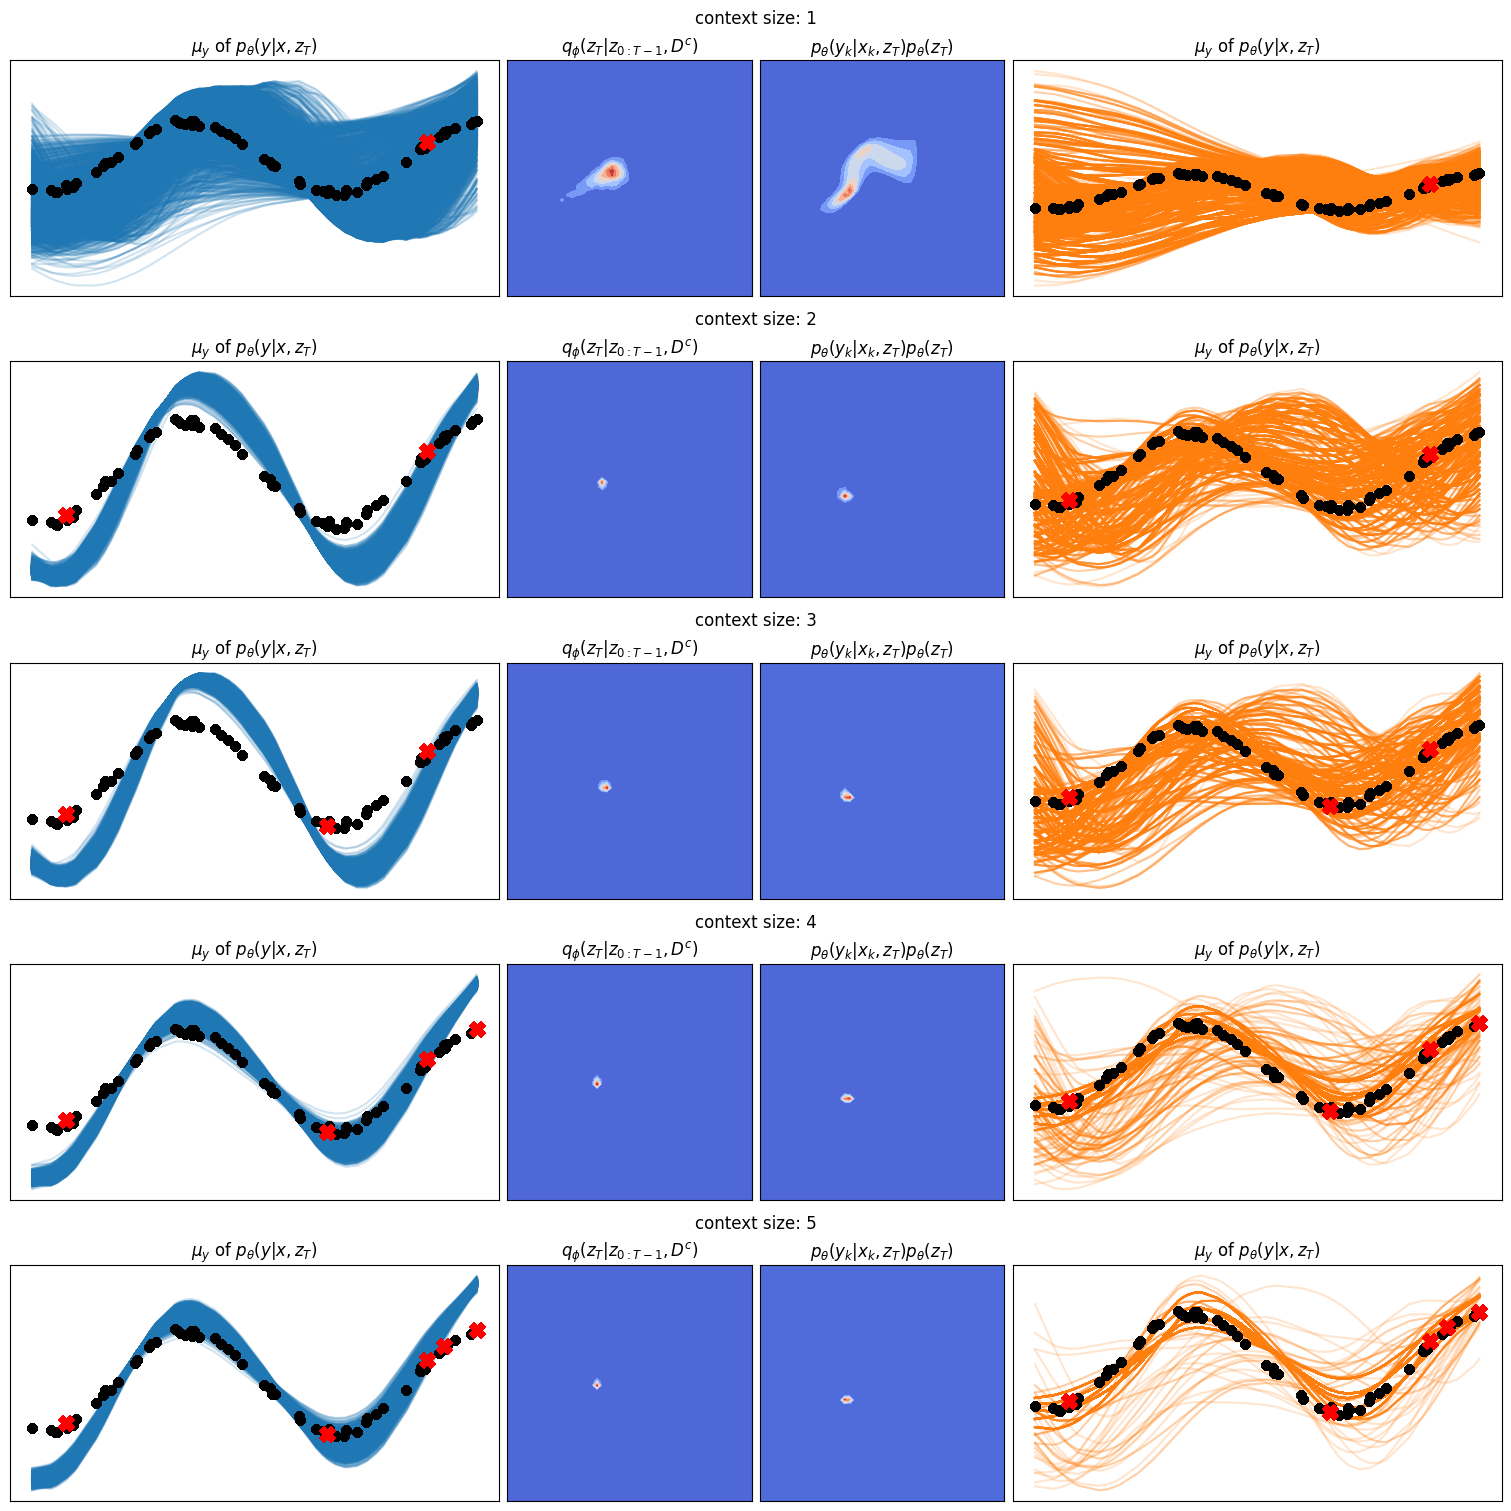

In [5]:
max_context_size = 5
num_samples = 2500
gen_dataloader = DataLoader(trainer.dataset, 1, True)

targets, samples = visualize_dvinp_both(
    device=device,
    dvinp=dvinp,
    dataloader=gen_dataloader,
    num_samples=num_samples,
    max_context_size=max_context_size,
    ranges=[(-5, 5), (-5, 5)],
)

In [8]:
!jupyter nbconvert --to script eval_bml.ipynb

[NbConvertApp] Converting notebook eval_bml.ipynb to script
[NbConvertApp] Writing 1614 bytes to eval_bml.py
